In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import pickle
from modules_gd.model import VAE

In [23]:
N = "5k"
MSA_id = "COG438-l150-s1"
model_name = "model_ld2_wd0.01_epoch100_2024-08-19"
processed_dir = f"data/simulations/processed/{MSA_id}"
msa_path = f"data/simulations/msas/{N}/{MSA_id}_msa.dat"
embeddings_path = f"embeddings/{MSA_id}/{model_name}_anc-embeddings.csv"

Get the ground truth simulated ancestral sequences

In [24]:
real_seqs_dict = {}
with open(msa_path, 'r') as msa:
    # Skips text before the beginning of the interesting block:
    for line in msa:
        if line.strip() == '9997 150':  # Change to more robust test
            break
    # Read only ancestral sequences
    for line in msa:  # This keeps reading the file
        id, seq = line.split()
        if id[0] != 'N':
            real_seqs_dict[id] = seq
print(len(real_seqs_dict))

4998


Load model that was used to produce the embeddings at the tips and

In [25]:
nl, nc = 150, 21
model_path = f"saved_models/{MSA_id}/{model_name}.pt"
model = VAE(nl = nl, nc = nc, dim_latent_vars=2) # initiate to have the right architecture for loading
model_state_dict = torch.load(model_path)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

## Get ancestral embeddings

Get ancestral embeddings that were saved from R script

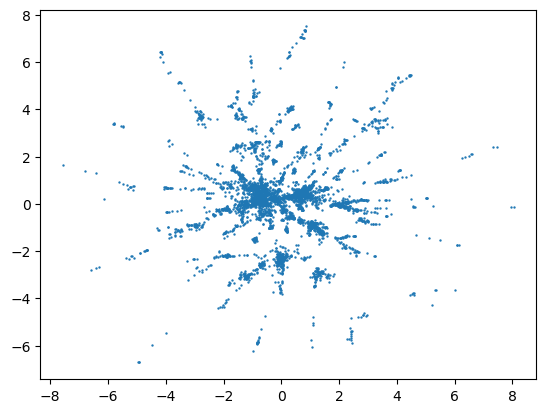

In [26]:
recon_embeds = pd.read_csv(embeddings_path, index_col=0)
anc_id = [str(id) for id in recon_embeds.index]
plt.scatter(recon_embeds['dim0'], recon_embeds['dim1'], s = .5)

Order the true ancestral sequences to match the order of our reconstructed sequences

In [27]:
# order real seqs according `anc_id`
real_seqs = [real_seqs_dict[k] for k in anc_id]
# print every 10th sequence
real_seqs[::10]

['KKDWVASLMKQIIFNALNIAAEEYFAQSASLNAQVQLTTTRFGPMNLTSTPESIATLLGIVVRVVAYQNAKARILNKNEIHCGERVNQNVDMAFVLPGLIQSSKFNEHVLRGHVAEYSESNAIKVFELSVKMCPQYFQKIPIRLIIAVGQ',
 'KRDWLSRLIRQVGFAALNVSSEEQYAQSAASNVQVEVSVTRFEPMNLRDNPETIASLYGSLVRVVAFVNGRARIVKKSEIHCGHRVDQKIDLEYLLPGLIDSTKYNETVRHCHVVEYSEQNAIRVFETSIKMCPRYFQKVPARLIVAAGE',
 'KTDWSSSLMKQAMFTAFNVAEEVYFAQAASLNQQVQLTATRFGPMSLTSVPEGIATLLGILVSIVAYQNAKARILHKNEIHSGERVNQKIDLAFVLPGLIQTSKYNDHVVHGQIADLSESNAIEVAELSVKMLPRYFQMLPIKLIIAVGE',
 'KRDWISSLLKNAMSNALDVANEEYFAKSGALRQQVSKTTTRFGPMNMTSVPESISTLLAILVKIVGYQNAKARILNKNEIHSGERVNQKLDVGFVIPGLINDSKYNDHTIHDHVAEYNESNNIKVIDLSVKLCPRYFLKIQIKLILAIGE',
 'KRDWISALMKNAMSNALNVAAEEYFAQTASLRQQVQKTNTRFGPMNMTSVPESIATLLEILVSIVGYQNAKARILNKNEIHSGERVNQKIDAGFVLPGLINDSKYNDHVIHGHVAEYSESNAIKVLKLSVKMCPRYFQKIQIKLIIAVGE',
 'KKHWVASFIRQILCNALNVSASEYFAQSKSLNQQVEVATDRFGAMNITSNPEAIAMQLGLVIRIIAYQNAPNRILNENEIHCNQHENQKVDMAFVLPGVLQSSRFNEHVWRGHVATYREGHAIKVFELSVKVCPRYFQRVPIKFIFSVGQ',
 'KKDWITSLCEQIIFNSLNIAAEEYIAQSKSLNAKAQLTTTRFGPMTLTSTPDSIATLMGIVVRVVTYQ

In [28]:
with open(f"{processed_dir}/aa_index.pkl", 'rb') as file_handle:
    aa_index = pickle.load(file_handle)

In [29]:
seq_ary = []
for seq in real_seqs:
    seq_ary.append([aa_index[c] for c in seq])
seq_ary = np.array(seq_ary)
K = 21 ## num of classes of aa
D = np.identity(K)
num_seq = seq_ary.shape[0]
len_seq = seq_ary.shape[1]
seq_ary_binary = np.zeros((num_seq, len_seq, K)) # Binary encoded array representing the processed MSA
for i in range(num_seq):
    seq_ary_binary[i,:,:] = D[seq_ary[i]]

In [30]:
seq_ary_binary = torch.from_numpy(seq_ary_binary).to(torch.float32)
with torch.no_grad():
  mu, sigma = model.encoder(seq_ary_binary)

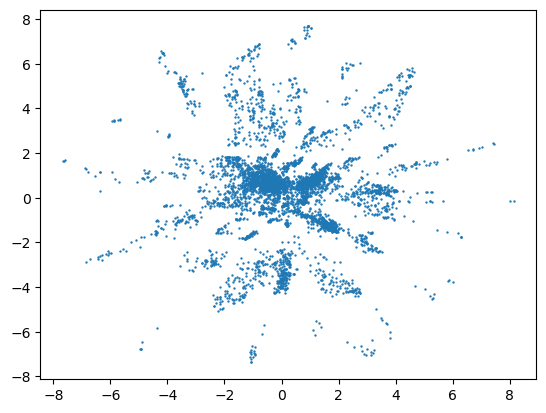

In [31]:
plt.scatter(mu[:, 0], mu[:, 1], s = .5)
plt.show()

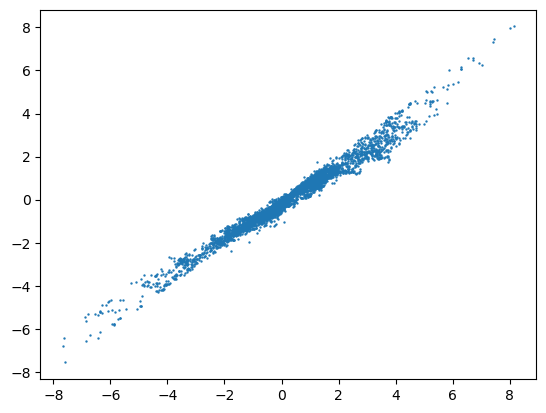

In [32]:
plt.scatter(mu[:,0], recon_embeds["dim0"], s=0.5)

## How well do decoded draws from prior match the true ancestral sequences?

Define how integers map to amino acids

In [33]:
with open(f"{processed_dir}/aa_index.pkl", 'rb') as file_handle:
    aa_index = pickle.load(file_handle)

# In our integer encoding of proteins, we've encoded several different amino acid characters as 0
# For decoding purposes, we will decode all 0's as '-'
del aa_index['.'], aa_index['X'], aa_index['B'], aa_index['Z'], aa_index['J'], 


idx_to_aa_dict = {}
for k, v in aa_index.items():
    idx_to_aa_dict[v] = k

In [34]:
# draws from the prior to be decoded
# z has to be a torch.tensor with a size of (num_seqs, dim_latent_space)
num_seqs = len(real_seqs)
dim_latent_space = model.dim_latent_vars
z = torch.randn(num_seqs, dim_latent_space)

# decode to amino acid probabilities
with torch.no_grad():
    log_p = model.decoder(z)
    p = torch.exp(log_p)
p = p.numpy()
p.shape
# covert probablities into actual protein sequences by choosing the most likely amino acid at each position.
max_prob_idx = np.argmax(p, -1)
prior_seqs = []
for i in range(num_seqs):
    seq = [idx_to_aa_dict[idx] for idx in max_prob_idx[i,:]]
    prior_seqs.append("".join(seq))
# print every 10th sequence
prior_seqs[::10]

['KKDWVASSLKQIIFNALNVAAAEYFAQAASLNAQVQFTTTRFGPTNLTSTPDSIATLLGIVIRVVAFANAKARVLNKNMVHCGERVNQNAELGFVLPGLIQASKFNEYLLRGHVAEYSASNAIKVFELSVRLCPQYFQKVPVRLIIAVGQ',
 'KKDWLASALKQVVFNALNVATAEYFAQSASLNGRVQFTTTRWGPTNLTSTPESLATLLGIVVRVVAYANAKARILNKNLIHCGERVNQNADMAFVLPGLIQSSKFNEHFLRGHVEEYSASNAIKVFELSIRLCPQYFQKIPVRLIIAVGQ',
 'KKDWVRSVLKQLICNALNIKVAEYFAQSASLNAQVQFTLTRFGPTNLTSEPDSIATLLGVVVRVVAYANAKAWILNKNMFHCAERVNQDSDLAFVLPGLIQSSKFNEHLCRGHVAEYSASNAIKVFELSVKLCPQYFQKVPIRLIYAVGQ',
 'DRNWVVEQMKQLLFSALDIAVVRHIPERAPLDLEVQILTKHFGPINLTSTPESLGTLLGAEDRVVAYQDAKNGILKYDEIHCGPRVNRNADLAYLLAGLINTSIFIEHYLRGHVGEYAESNAYKVFELSLKTCPQYYEQVCIRLIIAVGQ',
 'KKDWVGALRKQIVFYAINAAAEVFFVQKAALNVRVQLLTTRLGPNKLTSTPESVVALLSWPVRVVAYRNASSRVLNKNKFHCGERINISIDQDFVLPGLIQPTKSDEHVLRGHIADHRESNGIQIFELQIKMSPQYFQKAPIKLIIAVGT',
 'KKDWVASVLKQLIFNALNIAVAEYLAQSASLNAQVQFTKTRFGPTNLTSEPDTIATLLGVVVRVVAYANAKARILNKNILHCGERVNQNSDLAFVLPGLIQSSKFNENLLRGHVAEYSASDAIKVFELSVKMCPQYFQKIPIRLIIAVGQ',
 'KKDWVASTLKQIIFNALNIAVAEYFAQSASLNARVQFTTTRFGPTNLTSTPESIATLLGIVVRVVAYA

Check whether these "prior" sequences match the simulated ancestral sequences

correct: 351827
total: 745200
Percentage correct: 47.21


(array([  7.,  18.,  46., 100., 156., 223., 291., 357., 416., 413., 449.,
        354., 336., 278., 254., 209., 178., 173., 152., 129., 117.,  80.,
         66.,  45.,  35.,  36.,  20.,  18.,   8.,   4.]),
 array([0.14666667, 0.174     , 0.20133333, 0.22866667, 0.256     ,
        0.28333333, 0.31066667, 0.338     , 0.36533333, 0.39266667,
        0.42      , 0.44733333, 0.47466667, 0.502     , 0.52933333,
        0.55666667, 0.584     , 0.61133333, 0.63866667, 0.666     ,
        0.69333333, 0.72066667, 0.748     , 0.77533333, 0.80266667,
        0.83      , 0.85733333, 0.88466667, 0.912     , 0.93933333,
        0.96666667]),
 <BarContainer object of 30 artists>)

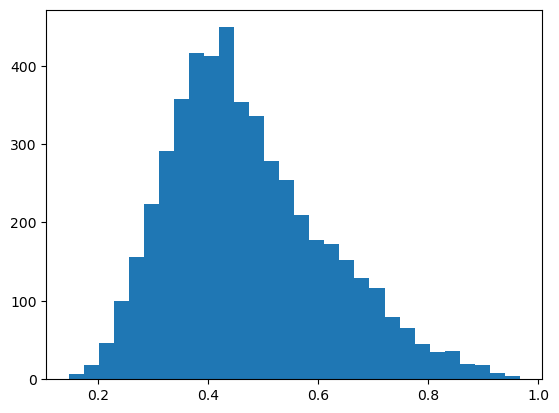

In [35]:
correct = 0
total = 0
acc = []
for (prior_seq, real_seq) in zip(prior_seqs, real_seqs):
  n_correct = sum([real_c == prior_c for (real_c, prior_c) in zip(real_seq, prior_seq)])
  correct += n_correct
  total += len(real_seq)
  acc.append(n_correct)
print(f"correct: {correct}")
print(f"total: {total}")
print(f"Percentage correct: {np.round(100*correct/total, 2)}")
acc = np.array(acc)/len(real_seqs[0])
plt.hist(acc, bins=30)

## How well do decoded ancestral embeddings match the true ancestral sequences?

Decode ancestral embeddings to sequences

In [36]:
# convert to torch tensor
mu = torch.tensor(recon_embeds.values , dtype=torch.float32)
# now we decode
with torch.no_grad():
  log_p = model.decoder(mu)
  p = torch.exp(log_p)
# Now we covert probablities into actual protein sequences by choosing the most likely amino acid at each position.
max_prob_idx = torch.argmax(p, -1)

# Decode the integer `max_prob_idx` to character and display reconstructed ancestral sequences
max_prob_idx = max_prob_idx.numpy()
recon_seqs = []
for i in range(len(max_prob_idx)):
    recon_seq = [idx_to_aa_dict[idx] for idx in max_prob_idx[i,:]]
    recon_seqs.append("".join(recon_seq))
# print every 10 sequences to compare with real sequences
recon_seqs[::10]

['KKDWLASLMKQIIFDALNIAAEEYFAQSASLNAQVQLTTTRFGPMNLTSTPESIATLLGVVVRVIAYQNAKARILNKNEVHCGERVNQNVDMAFVLPGLIQSSKFNEHLLRGHVAEYSESNAIKVFELSVKMCPQYFQKVPVRLILAVGQ',
 'KKDWLASLMEQIIFNALNIAAEEYFAQSASLNAQVQLTTTRFGPLNLTSTPESIATLLGVVVRIIAYQNAKARILNKNEIHCGERVNQNVDMAFVLPGLIQSSKFNEHVLRGHVAEYSESNAIKVFELSVKMCPQYFQKIPIRLILAVGQ',
 'KKDWLASLMEQIIFNALNIAAEEYFAQSASLNAQVQLTTTRFGPMNLTSTPESIATLLGIVVRVIAYQNAKARILNKNEIHCGERVNQNVDMAFVLPGLIQSSKFNEHLLRGHVAEYSESNAIKVFELSVKMCPQYFQKIPIRLILAVGQ',
 'KKDWLASLMKQIIFNALNIAAEEYFAQSASLNAQVQLTTTRFGPMNLTSTPESIATLLGIVVRVIAYQNAKARILNKNEIHCGERVNQNVDMAFVLPGLIQSSKFNEHLLRGHVAEYSESNAIKVFELSVKMCPQYFQKIPIRLILAVGQ',
 'KKDWLASLMKQIIFDALNIAAEEYFAQSASLNAQVQLTTTRFGPMNLTSTPESIATLLGVVVRVIAYQNAKARILNKNEIHCGERVNQNVDMAFVLPGLIQSSKFNEHLLRGHVAEYSESNAIKVFELSVKMCPQYFQKIPIRLILAVGQ',
 'KKDWVASLMKQIIFNALNIAAEEYFAQSASLNAQVQLTTTRFGPMNLTSTPESIATLLGVVVRVVAYQNAKARILNKNEVHCGERVNQNVDMAFVLPGLIQSSKFNEHLLRGHVAEYSESNAIKVFELSVKMCPQYFQKIPVRLIIAVGQ',
 'KKDWLASLMEQIIFNALNIAAEEYFAQSASLNAQVQLTTTRFGPLNLTSTPESIATLLGIVVRIIAYQ

Calculate accuracy of reconstructed ancestral sequences

correct: 511243
total: 745200
Percentage correct: 68.6


(array([  2.,   3.,  10.,  14.,  28.,  34.,  60., 109., 115., 113., 174.,
        212., 197., 261., 264., 278., 287., 307., 296., 207., 296., 292.,
        268., 261., 258., 218., 178., 123.,  85.,  18.]),
 array([0.22 , 0.246, 0.272, 0.298, 0.324, 0.35 , 0.376, 0.402, 0.428,
        0.454, 0.48 , 0.506, 0.532, 0.558, 0.584, 0.61 , 0.636, 0.662,
        0.688, 0.714, 0.74 , 0.766, 0.792, 0.818, 0.844, 0.87 , 0.896,
        0.922, 0.948, 0.974, 1.   ]),
 <BarContainer object of 30 artists>)

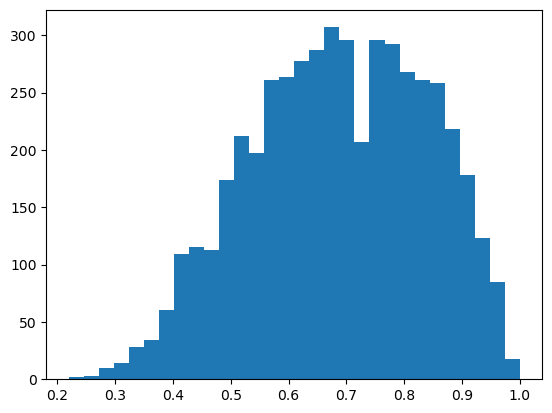

In [37]:
correct = 0
total = 0
acc = []
for (recon_seq, real_seq) in zip(recon_seqs, real_seqs):
  n_correct = sum([real_c == recon_c for (real_c, recon_c) in zip(recon_seq, real_seq)])
  correct += n_correct
  total += len(real_seq)
  acc.append(n_correct)
print(f"correct: {correct}")
print(f"total: {total}")
print(f"Percentage correct: {np.round(100*correct/total, 2)}")
acc = np.array(acc)/len(real_seqs[0])
plt.hist(acc, bins=30)

## Baseline: just predict modal character at leaves for all ancestors:

In [38]:
with open(f"{processed_dir}/seq_msa.pkl", 'rb') as file_handle:
    real_seq_leaves_int = pickle.load(file_handle)
real_seq_leaves = []
for i in range(real_seq_leaves_int.shape[0]):
    seq = [idx_to_aa_dict[idx] for idx in real_seq_leaves_int[i,:]]
    real_seq_leaves.append("".join(seq))

KKDWVASLLKQIIFNALNIAVEEYFAQSASLNAQVQLTTTRFGPLNLTSTPESIATLLGIVVRVVAYQNAKARILNKNEIHCGERVNQNADLAFVLPGLIQSSKFNEHLLRGHVAEYSESNAIKVFELSVKLCPQYFQKIPIRLIIAVGQ
correct: 423495
total: 745200
Percentage correct: 56.83


(array([  1.,   4.,   3.,  21.,  42.,  78., 144., 231., 274., 344., 313.,
        313., 331., 323., 302., 246., 286., 254., 216., 218., 167., 179.,
        135., 130., 106.,  99.,  69.,  69.,  44.,  26.]),
 array([0.16666667, 0.19355556, 0.22044444, 0.24733333, 0.27422222,
        0.30111111, 0.328     , 0.35488889, 0.38177778, 0.40866667,
        0.43555556, 0.46244444, 0.48933333, 0.51622222, 0.54311111,
        0.57      , 0.59688889, 0.62377778, 0.65066667, 0.67755556,
        0.70444444, 0.73133333, 0.75822222, 0.78511111, 0.812     ,
        0.83888889, 0.86577778, 0.89266667, 0.91955556, 0.94644444,
        0.97333333]),
 <BarContainer object of 30 artists>)

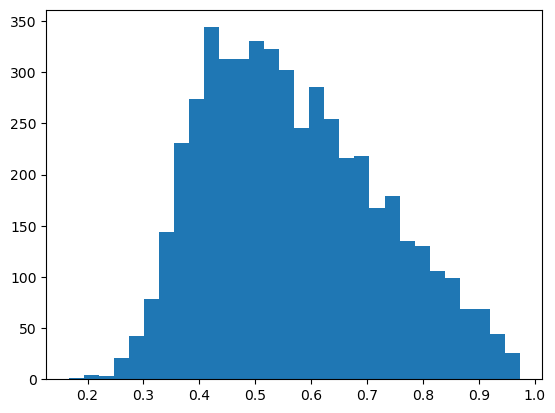

In [39]:
maj_seq = []
for i in range(len(real_seqs[0])):
    col = [seq[i] for seq in real_seq_leaves]
    maj_seq.append(max(set(col), key=col.count))
maj_seq = "".join(maj_seq)
print(maj_seq)
maj_seqs = [maj_seq] * len(real_seqs)
correct = 0
total = 0
acc = []
for (maj_seq, real_seq) in zip(maj_seqs, real_seqs):
  n_correct = sum([real_c == maj_c for (real_c, maj_c) in zip(real_seq, maj_seq)])
  correct += n_correct
  total += len(real_seq)
  acc.append(n_correct)
print(f"correct: {correct}")
print(f"total: {total}")
print(f"Percentage correct: {np.round(100*correct/total, 2)}")
acc = np.array(acc)/len(real_seqs[0])
plt.hist(acc, bins=30)

## Baseline 2: IQTree Reconstruction

Get the iqtree reconstructed ancestral sequences dataframe and drop the columns that give probabilities

In [40]:
iq_df = pd.read_table(f'data/simulations/processed/{MSA_id}/seq_msa_char.fasta.state', header=8)
iq_df_sk = iq_df[["Node", "Site", "State"]]
iq_df_sk = iq_df_sk.sort_values(by=["Node", "Site"])
iq_df_sk.set_index("Node", inplace=True)
iq_df_sk

,Site,State
Node,,
Node1,1,K
Node1,2,K
Node1,3,D
Node1,4,W
Node1,5,V
...,...,...
Node999,146,I
Node999,147,A
Node999,148,A


Get list of IQTree reconstructed ancestral sequences to match the order of our reconstructed sequences.
This code is kinda slow:

In [41]:
if N == "5k":
    N = 5000
iq_seqs = []
for k in anc_id:
    node_id = f"Node{int(k) - N}"
    recon_seq_df = iq_df_sk.loc[node_id]
    recon_seq = "".join(recon_seq_df.State.values)
    iq_seqs.append(recon_seq)
iq_seqs[::10]

['KKDWVASLMKQIIFNALNIAAEEYFAQSASLNAQVQLTTTRFGPMNLTSTPESIATLLGIVVRVVAYQNAKARILNKNEIHCGERVNQNVDMAFVLPGLIQSSKFNEHVLRGHVAEYSESNAIKVFELSVKMCPQYFQKIPIRLIIAVGQ',
 'KRDWLSKLIRQVGFAALNVSAEGQFAQSAAANVQVEVSVTRFSPLNLRDNPETIASLLGGLVRVIAFVNGKARILKKSEIHCGHRVDQKIDLEYILPGLIQSSKYNETIRHCHVAEYSEQNAIRVFETSIKMCPRYVQKVPARLIVAAGE',
 'KTDWTSSLMKQAMFTALNVAAEAYFAQSAHLNQQVQLTATRFGPMSLTSVPENIATLLGILVTIVAYQNAKARILHKNEIHCGDRVNKKIDLAFVLPGLIQTSKYNEHVIHGHVADLSESNAIEVTELSVKMLPRYFQKIPIKLIIAVGE',
 'KREWVSALMKIAMSNALNVANEEYFAKSGSLRQQVSKTTTRFGPMNMSSVPESIATLLAILVKIVGYQNAKARILNKNEIHSGERVNQKIDAGFVLPGLINDSKYNDHTIHGHVAEYSESNAIKVVALSVKMCPRYFLKIQIKLIIAVGE',
 'KRDWVSALMKNAMSNALNVAAEEYFAQSASLRQQVQKTTTRFGPMNMSSVPESIATLLAILVSIVGYQNAKARILNKNEIHSGERVNQKIDAGFVLPGLINDSKYNDHVIHGHVAEYSESNAIKVLALSVKMCPRYFQKIQIKLIIAVGE',
 'KKHWVDALIRQILLNALNATASEYFQQSKSLNQQVEVATDRFGAMNLTSNPEAIAMQLGLVVRIVAYPNAPNRILNENEIHCNQHKNQKIDLAFVLPGVLQSSRFNEHVFRGHVATYREGHAIKVFELAVKICPRYFQKIPIKLIFSVGQ',
 'KKDWLASLCEQIIFNSLNIAAEEYIAQSKSLNAKAQLTTTRFGPMTLTSTPDSIATLMGIIVRVVTYQ

correct: 688145
total: 745200
Percentage correct: 92.34


(array([  1.,   0.,   1.,   2.,   1.,   2.,   3.,   5.,  10.,  16.,  22.,
         27.,  29.,  60.,  71.,  70.,  98., 102., 162., 170., 213., 249.,
        383., 194., 366., 415., 432., 476., 508., 880.]),
 array([0.6       , 0.61333333, 0.62666667, 0.64      , 0.65333333,
        0.66666667, 0.68      , 0.69333333, 0.70666667, 0.72      ,
        0.73333333, 0.74666667, 0.76      , 0.77333333, 0.78666667,
        0.8       , 0.81333333, 0.82666667, 0.84      , 0.85333333,
        0.86666667, 0.88      , 0.89333333, 0.90666667, 0.92      ,
        0.93333333, 0.94666667, 0.96      , 0.97333333, 0.98666667,
        1.        ]),
 <BarContainer object of 30 artists>)

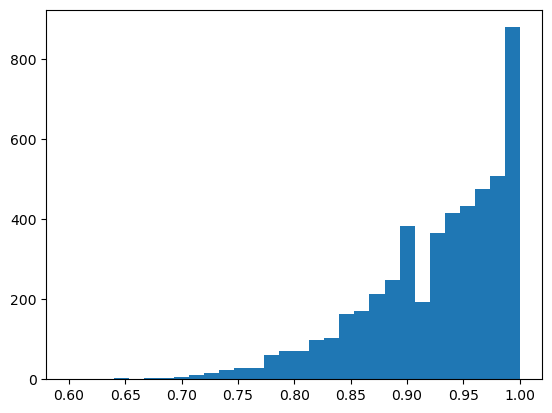

In [42]:
correct = 0
total = 0
acc = []
for (recon_seq, real_seq) in zip(iq_seqs, real_seqs):
  n_correct = sum([real_c == recon_c for (real_c, recon_c) in zip(recon_seq, real_seq)])
  correct += n_correct
  total += len(real_seq)
  acc.append(n_correct)
print(f"correct: {correct}")
print(f"total: {total}")
print(f"Percentage correct: {np.round(100*correct/total, 2)}")
acc = np.array(acc)/len(real_seqs[0])
plt.hist(acc, bins=30)